<a href="https://colab.research.google.com/github/Camilojaravila/202120_ISIS4219_01-MACHINE_LEARNING_TECHNIQUES/blob/main/Taller%204/Laboratorio%204%20-%20Sesi%C3%B3n%201.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

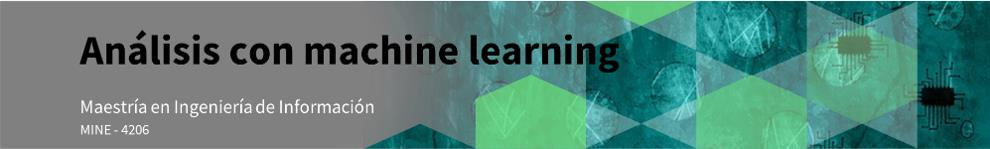

La comunidad científica es de la comunidad más activa que existe a la hora de realizar publicaciones en grandes revistas. Los avances tecnológicos, las facilidades a la hora de encontrar información y la gran cantidad de médicos dedicados a realizar estudios y publicarlos ha aumentado a tal punto que realizar una categorización de estos textos sería ideal para poder filtrar la información y acceder a ella de una manera más rápida y precisa.

Un análisis importante dentro de la comunidad es determinar cuales son los tópicos que más fuerza ha tomado en los estudios y cuales son los temas reelevantes en los *Abstracts* que son publicados. Y poder determinar cuales relaciones o características existen entre los textos médicos analizados.


## Objetivos

*   Aplicar las técnicas vistas de procesamiento de textos.
*   Realizar el entrenamiento de un modelo no supervisado.
*   Interpretar los resultados de un modelo de agrupación.



In [2]:
!pip install pattern

     |████████████████████████████████| 22.2 MB 1.2 MB/s 
     |████████████████████████████████| 87 kB 6.9 MB/s 
     |████████████████████████████████| 81 kB 9.5 MB/s 
     |████████████████████████████████| 5.6 MB 37.7 MB/s 
     |████████████████████████████████| 5.6 MB 23.9 MB/s 
     |████████████████████████████████| 419 kB 41.7 MB/s 
     |████████████████████████████████| 104 kB 69.8 MB/s 
     |████████████████████████████████| 4.0 MB 34.5 MB/s 
  Created wheel for pattern: filename=Pattern-3.6-py3-none-any.whl size=22332721 sha256=86aea7ddfa60c6dd3ecbfcb1b5a7386c9c1d1026a498bc9414fd4e0a1c4b9ca2
  Stored in directory: /root/.cache/pip/wheels/8d/1f/4e/9b67afd2430d55dee90bd57618dd7d899f1323e5852c465682
  Created wheel for mysqlclient: filename=mysqlclient-2.1.0-cp37-cp37m-linux_x86_64.whl size=99956 sha256=8abec19d6e9d947fed3e8f2b4a4d72f00d1444ebec771f4c76483324ac6aa59b
  Stored in directory: /root/.cache/pip/wheels/97/d4/df/08cd6e1fa4a8691b268ab254bd0fa589827ab5b65638c010b4
  

In [3]:
import pandas as pd
import numpy as np
import sys
import os
import os.path as osp

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans, DBSCAN
from sklearn.decomposition import IncrementalPCA
from sklearn.metrics import silhouette_score, silhouette_samples, rand_score

import nltk
nltk.download('punkt')

from nltk import word_tokenize
from pattern.text.en import singularize

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


### Perfilamiento y entendimiento de los datos


#### Lectura de los datos
Realizamos la carga de nuestros datos y, como ya lo analizamos anteriormente, determinamos a que categoría pertenece cada texto para que sea más legible.

In [4]:
url = 'https://raw.githubusercontent.com/Camilojaravila/202210_MINE-4206_ANALISIS_CON_MACHINE_LEARNING/main/Taller%202/train.dat'
datos = pd.read_csv(url, sep="\t",header=None)
dic = {
1: 'Neoplasms',
2: 'Digestive System Diseases',
3: 'Nervous System Diseases',
4: 'Cardiovascular Diseases',
5: 'General Pathological Conditions'
}
datos[0].replace(dic,inplace=True)

datos


,0,1
0,Cardiovascular Diseases,Catheterization laboratory events and hospital...
1,General Pathological Conditions,Renal abscess in children. Three cases of rena...
2,Digestive System Diseases,Hyperplastic polyps seen at sigmoidoscopy are ...
3,General Pathological Conditions,Subclavian artery to innominate vein fistula a...
4,Cardiovascular Diseases,Effect of local inhibition of gamma-aminobutyr...
...,...,...
14433,Cardiovascular Diseases,Quadricuspid aortic valve and aortic regurgita...
14434,Neoplasms,Mammographic measurements before and after aug...
14435,Neoplasms,Use of leukocyte-depleted platelet concentrate...
14436,Digestive System Diseases,Complications of Tenckhoff catheters post remo...


In [5]:
ind = datos.groupby(0)[1].apply(lambda s: s.sample(1000, random_state=33)).index.get_level_values(1)
ind

df = datos[datos.index.isin(ind)]
df

,0,1
2,Digestive System Diseases,Hyperplastic polyps seen at sigmoidoscopy are ...
6,General Pathological Conditions,Mediastinal tracheostomy using a pectoralis ma...
10,General Pathological Conditions,Usefulness of the automatic implantable cardio...
22,Neoplasms,Follicular thyroid cancer treated at the Mayo ...
28,Nervous System Diseases,Lexical organization of nouns and verbs in the...
...,...,...
14424,General Pathological Conditions,Pyloric deformation from peptic disease. Radio...
14431,Nervous System Diseases,Early diagnosis and survival of ruptured abdom...
14433,Cardiovascular Diseases,Quadricuspid aortic valve and aortic regurgita...
14436,Digestive System Diseases,Complications of Tenckhoff catheters post remo...


#### Preprocesamiento de los Datos

Para la transformación, en este caso como vamos a determinar la importancia de diferentes palabras dentro de los documentos y cuales son las más significativas entre las categorías, se decide utilizar la transformación [Tf-idf](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfTransformer.html#sklearn.feature_extraction.text.TfidfTransformer).

In [6]:
vectorizer = TfidfVectorizer(stop_words="english")
X = pd.DataFrame(vectorizer.fit_transform(df[1]).toarray())
X.head()

,0,1,2,3,4,5,6,7,8,9,...,25181,25182,25183,25184,25185,25186,25187,25188,25189,25190
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Y, ante la gran cantidad de columnas o tributos que tiene nuestro conjunto de datos, realizaremos un PCA para poder realizar una Reducción de la Dimensionalidad.

In [ ]:
for i in range(100,10001,100):
    print(i)
    transformer = IncrementalPCA(n_components=i)
    transformer.fit(X)
    print(transformer.explained_variance_ratio_.sum())

100
0.15897809874869798
200
0.24313676965681535
300
0.3084115031821335
400
0.36308117737492895
500
0.4107213045019461
600
0.4531229183820459
700
0.49127934606006957
800
0.5260062755886765
900
0.5578181869641702
1000
0.5871673941962448
1100
0.6143901257948262
1200
0.6397372368088851
1300
0.6634277137731375
1400
0.6856620680399398
1500
0.7065824993809003
1600
0.7263077923421768
1700
0.7449492063070782
1800
0.7625891004123386
1900
0.7793007512368983
2000
0.7951505702145099
2100
0.8101915205515198
2200
0.8244584542078794
2300
0.8379984011663666
2400
0.8508513761628984
2500
0.8630341388486907
2600
0.8745844107778524
2700
0.8855270733709342
2800
0.8958859164095708
2900
0.9056769854504474
3000
0.9149242584916848
3100
0.9236426176546515
3200
0.9318555135645525
3300
0.9395754921620361
3400
0.9468197444833064
3500
0.953595817833762
3600
0.9599164367939292
3700
0.965796478773286
3800
0.9712464417519215
3900
0.9762815319229932
4000
0.9809071170375073
4100
0.985133362887692
4200
0.9889605072113212


Luego de una búsqueda rápida, seleccionamos 3000 componentes para realizar nuestra transformación.

In [7]:
transformer = IncrementalPCA(n_components=3000)
X_transformed = transformer.fit_transform(X)
print(transformer.explained_variance_ratio_.sum())
X_transformed

0.9149242584916848


array([[-0.01851256,  0.01910397,  0.00137756, ..., -0.01157004,
        -0.00054197,  0.01308924],
       [-0.02588792,  0.00859993, -0.05379341, ...,  0.0107556 ,
         0.01065435,  0.00820426],
       [ 0.23203882,  0.01279724,  0.01048217, ..., -0.00141067,
         0.00574307,  0.01306273],
       ...,
       [ 0.06500666, -0.0101556 , -0.11350958, ...,  0.00585435,
         0.02464353,  0.00952335],
       [ 0.05420063,  0.04256981, -0.02667738, ..., -0.00677891,
        -0.03369566,  0.00925391],
       [ 0.09978103, -0.06124223, -0.08480795, ..., -0.01857025,
        -0.00577322,  0.01371065]])

### Modelamiento

Para cumplir el primer objetivo, utilizamos un aprendizaje no supervisado, ya que lo que queremos es obtener las propiedades principales de cada uno de los textos. En este caso se puede utilizar el algoritmo de K-Means.

Sin embargo, K-Means es muy sensible a las condiciones iniciales...

In [12]:
def buscar_semilla(semilla):
    print(semilla)
    k = 5
    model = KMeans(n_clusters=k,random_state=semilla)
    model.fit(X_transformed)
    terms = vectorizer.get_feature_names()

    pred = model.labels_
    categorias = datos[0].unique()

    inverso = dict()
    for x in categorias:
        d = pd.Series(pred[df[0]==x])
        print('Categoria: %s' % x)
        print(d.value_counts())
        num = d.value_counts().index[0]
        inverso[num] = x

    print(inverso)
    s = rand_score(df[0], pred)
    print("Score: ", s)
    return s

Para eso, evaluaremos diferentes semillas para poder evidenciar la diferencia de los modelos construidos.

In [13]:
candidatos = [9,22,33,41]

for sem in candidatos:
    buscar_semilla(sem)
    print('-'*50)

9


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


Categoria: Cardiovascular Diseases
3    391
2    316
4    198
1     84
0     11
dtype: int64
Categoria: General Pathological Conditions
4    381
2    259
1    167
3    107
0     86
dtype: int64
Categoria: Digestive System Diseases
2    357
4    308
1    256
0     74
3      5
dtype: int64
Categoria: Neoplasms
1    310
0    309
4    268
2    107
3      6
dtype: int64
Categoria: Nervous System Diseases
4    556
2    265
1     98
3     42
0     39
dtype: int64
{3: 'Cardiovascular Diseases', 4: 'Nervous System Diseases', 2: 'Digestive System Diseases', 1: 'Neoplasms'}
Score:  0.6798977395479096
--------------------------------------------------
22


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


Categoria: Cardiovascular Diseases
2    363
3    235
0    224
1    173
4      5
dtype: int64
Categoria: General Pathological Conditions
0    421
1    262
2    182
4     78
3     57
dtype: int64
Categoria: Digestive System Diseases
1    388
0    345
2    181
4     84
3      2
dtype: int64
Categoria: Neoplasms
4    441
0    270
1    224
2     65
dtype: int64
Categoria: Nervous System Diseases
0    571
1    194
2    176
4     34
3     25
dtype: int64
{2: 'Cardiovascular Diseases', 0: 'Nervous System Diseases', 1: 'Digestive System Diseases', 4: 'Neoplasms'}
Score:  0.6729141028205641
--------------------------------------------------
33


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


Categoria: Cardiovascular Diseases
3    378
1    263
4    219
2    135
0      5
dtype: int64
Categoria: General Pathological Conditions
1    495
2    299
3    114
0     57
4     35
dtype: int64
Categoria: Digestive System Diseases
2    509
1    394
0     48
4     43
3      6
dtype: int64
Categoria: Neoplasms
0    440
1    374
2    174
4      8
3      4
dtype: int64
Categoria: Nervous System Diseases
1    592
2    307
4     38
3     36
0     27
dtype: int64
{3: 'Cardiovascular Diseases', 1: 'Nervous System Diseases', 2: 'Digestive System Diseases', 0: 'Neoplasms'}
Score:  0.6586372474494899
--------------------------------------------------
41
Categoria: Cardiovascular Diseases
1    351
0    317
2    181
3    136
4     15
dtype: int64
Categoria: General Pathological Conditions
2    303
0    293
3    213
4    102
1     89
dtype: int64
Categoria: Digestive System Diseases
3    336
0    314
2    261
4     85
1      4
dtype: int64
Categoria: Neoplasms
4    319
2    271
3    264
0    140
1  

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


### Validación

Y ya con nuestros clústers armados, podemos ver el coeficiente de silueta de cada uno de los grupos.

For seed = 9 The average silhouette_score is : 0.0011333305934205643
For seed = 22 The average silhouette_score is : 0.0005294278654122649
For seed = 33 The average silhouette_score is : -0.00023200895293356102
For seed = 41 The average silhouette_score is : 0.0009868583889120293


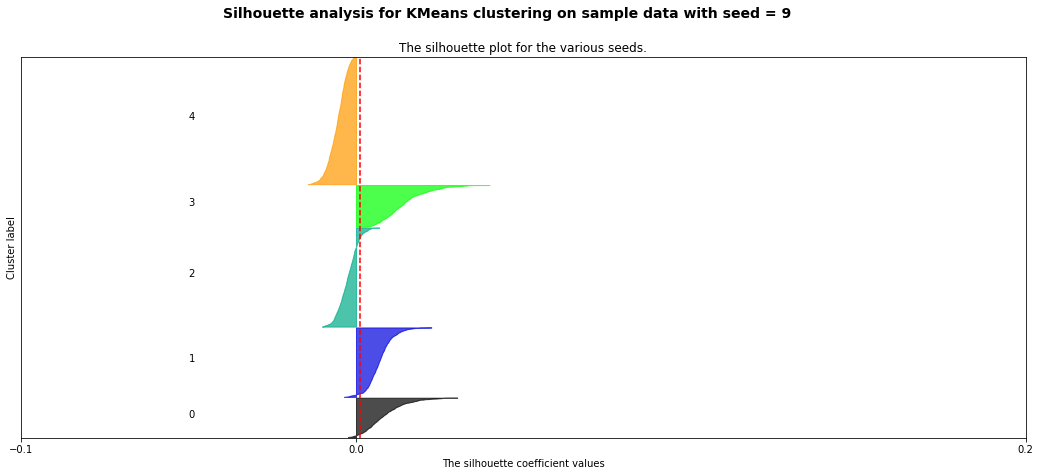

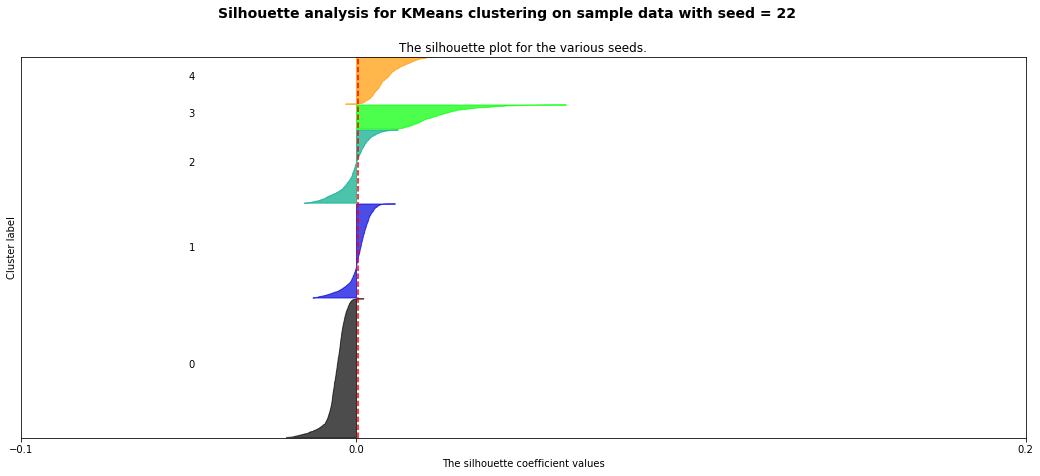

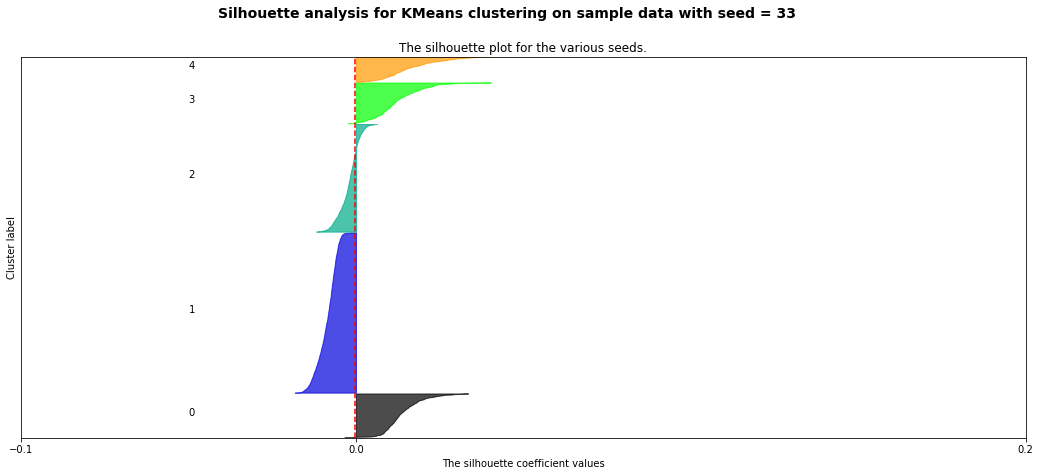

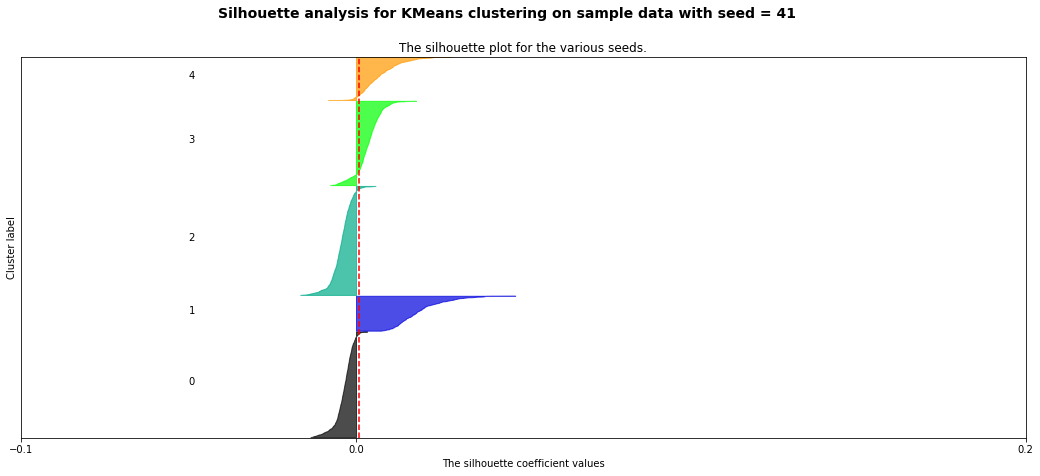

In [15]:
for n, sem in enumerate(candidatos):
    fig, ax1 = plt.subplots(1, 1)
    fig.set_size_inches(18, 7)
    ax1.set_xlim([-0.1, 0.2])
    ax1.set_ylim([0, len(X) + (n + 1) * 10])

    clusterer = KMeans(n_clusters=5, random_state=sem)
    cluster_labels = clusterer.fit_predict(X_transformed)


    silhouette_avg = silhouette_score(X_transformed, cluster_labels)
    print(
        "For seed =",
        sem,
        "The average silhouette_score is :",
        silhouette_avg,
    )

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(X_transformed, cluster_labels)

    y_lower = 10
    for i in range(5):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / 5)
        ax1.fill_betweenx(
            np.arange(y_lower, y_upper),
            0,
            ith_cluster_silhouette_values,
            facecolor=color,
            edgecolor=color,
            alpha=0.7,
        )

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various seeds.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2])

    plt.suptitle(
        "Silhouette analysis for KMeans clustering on sample data with seed = %d"
        % sem,
        fontsize=14,
        fontweight="bold",
    )

plt.show()

Vemos que los resultados a pesar de todo, no dan buenos resultados. Así que realizaremos otra estrategia.

In [16]:
def stem(plurals):
    singles = [singularize(plural) for plural in plurals]
    return ' '.join(singles)

Tomaremos esta vez todo nuestros datos, pero construiremos subcategorias en vez de categorias. Y le realizaremos una pequeña limpieza en los textos.

In [18]:
subcategorias = dict()
categorias = datos[0].unique()

display(datos.loc[datos[0]==categorias[0],1])

info = datos.loc[datos[0]==categorias[0],1]
info = info.apply(word_tokenize)
info = info.apply(lambda x: stem(x))

info

0        Catheterization laboratory events and hospital...
4        Effect of local inhibition of gamma-aminobutyr...
34       Radiographic manifestations of anomalies of th...
37       The Mansfield Scientific Aortic Valvuloplasty ...
43       Cardiac rhythm disturbances early after orthot...
                               ...                        
14422    Use of a computerized closed-loop sodium nitro...
14427    Giant-cell arteritis of the uterus with associ...
14428    The determinants and prognostic significance o...
14432    Embolization with particles in thoracic intram...
14433    Quadricuspid aortic valve and aortic regurgita...
Name: 1, Length: 3051, dtype: object

0        Catheterization laboratory event and hospital ...
4        Effect of local inhibition of gamma-aminobutyr...
34       Radiographic manifestation of anomaly of the l...
37       The Mansfield Scientific Aortic Valvuloplasty ...
43       Cardiac rhythm disturbance early after orthoto...
                               ...                        
14422    Use of a computerized closed-loop sodium nitro...
14427    Giant-cell arteritis of the uteru with associa...
14428    The determinant and prognostic significance of...
14432    Embolization with particle in thoracic intrame...
14433    Quadricuspid aortic valve and aortic regurgita...
Name: 1, Length: 3051, dtype: object

Así, con cada una de las categorias, determinaremos cuales son las palabras que definen mi centroide construido como subcategorias.

In [17]:
subcategorias = dict()
categorias = datos[0].unique()

for cat in categorias:
    print('-'*20 + cat + '-'*20)
    info = datos.loc[datos[0]==cat,1]
    info = info.apply(word_tokenize)
    info = info.apply(lambda x: stem(x))
    vectorizer = TfidfVectorizer(stop_words="english")
    X = vectorizer.fit_transform(info)
    k = 3
    subcategorias[cat] = KMeans(n_clusters=k,random_state=33)
    subcategorias[cat].fit(X)
    order_centroids = subcategorias[cat].cluster_centers_.argsort()[:, ::-1]
    terms = vectorizer.get_feature_names_out()
    pred = subcategorias[cat].labels_
    tabla = dict()
    for i in range(k):
        tabla[i] = [terms[ind] for ind in order_centroids[i, :10]]

    display(pd.DataFrame(tabla))

--------------------Cardiovascular Diseases--------------------


,0,1,2
0,pressure,patient,patient
1,blood,coronary,wa
2,hypertension,ventricular,aortic
3,wa,myocardial,case
4,effect,group,artery
5,rat,wa,valve
6,patient,artery,aneurysm
7,hypertensive,left,disease
8,heart,infarction,year
9,cholesterol,les,thi


--------------------General Pathological Conditions--------------------


,0,1,2
0,patient,cell,patient
1,wa,gene,wa
2,case,tumor,group
3,thi,dna,year
4,child,protein,coronary
5,syndrome,carcinoma,les
6,disease,wa,artery
7,treatment,human,rate
8,infection,patient,month
9,study,mouse,surgery


--------------------Digestive System Diseases--------------------


,0,1,2
0,ulcer,patient,liver
1,gastric,wa,hepatitis
2,pylorus,disease,patient
3,duodenal,case,wa
4,patient,treatment,cell
5,gastritis,group,cirrhosi
6,wa,thi,viru
7,peptic,esophageal,infection
8,helicobacter,year,hepatic
9,omeprazole,stone,serum


--------------------Neoplasms--------------------


,0,1,2
0,cell,patient,patient
1,tumor,survival,cancer
2,human,wa,case
3,carcinoma,tumor,wa
4,dna,year,tumor
5,wa,cancer,thi
6,gene,treatment,lesion
7,expression,stage,year
8,receptor,disease,carcinoma
9,growth,therapy,diagnosi


--------------------Nervous System Diseases--------------------


,0,1,2
0,stroke,patient,case
1,cerebral,wa,patient
2,patient,pain,syndrome
3,artery,group,wa
4,infarction,seizure,nerve
5,carotid,child,thi
6,wa,treatment,tumor
7,blood,year,cell
8,risk,study,disease
9,brain,sleep,muscle
